# MLP

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/Master_thesis/master_thesis_collab

/content/drive/MyDrive/Colab Notebooks/Master_thesis/master_thesis_collab


## Load python packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functions_2_ as fun
import deep_learning_helper as dp
import keras
import tensorflow as tf
import sklearn

%load_ext autoreload
%autoreload 2

from keras import models
from tensorflow.keras import layers

# Load the data 

In [4]:
# load the dataset
dataset = pd.read_csv('training_data.csv')
# dropp unncecassary columns
dataset = dataset.drop(['Unnamed: 0'], axis = 1)
dataset.head()

,epoch_utc,emission_factor,datetime_de,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,...,DK_import,DK_export,LU_import,LU_export,NL_import,NL_export,PL_import,PL_export,CH_import,CH_export
0,1.546297e+09,298.240217,2018-12-31 23:00:00+00:00,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,...,901.0,0.0,12.0,418.0,0.0,1354.0,224.0,0.0,0.0,800.0
1,1.546301e+09,266.522473,2019-01-01 00:00:00+00:00,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,...,316.0,0.0,16.0,398.0,0.0,1158.0,0.0,0.0,1.0,801.0
2,1.546304e+09,262.594215,2019-01-01 01:00:00+00:00,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,...,0.0,405.0,19.0,379.0,0.0,1176.0,0.0,0.0,0.0,800.0
3,1.546308e+09,260.190772,2019-01-01 02:00:00+00:00,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,...,0.0,619.0,23.0,373.0,0.0,1428.0,0.0,0.0,0.0,800.0
4,1.546312e+09,250.496683,2019-01-01 03:00:00+00:00,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,...,0.0,689.0,27.0,370.0,0.0,1492.0,0.0,0.0,0.0,800.0


In [5]:
# Split dataset int targe = co2 emisssions and features

# get co2 emissions
co2 = dataset['emission_factor']

# get features
cols_features = [c for c in dataset.columns if c != 'emission_factor']
cols = {c: i for i, c in enumerate(dataset.columns)}
indices = {ind: i for i, ind in enumerate(dataset.index)}
features = dataset.loc[:, [j for j in cols if j != 'emission_factor' and j in cols_features]]

In [6]:
# check co2 data
co2.head()

0    298.240217
1    266.522473
2    262.594215
3    260.190772
4    250.496683
Name: emission_factor, dtype: float64

In [7]:
# check features
features.head()

,epoch_utc,datetime_de,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,...,DK_import,DK_export,LU_import,LU_export,NL_import,NL_export,PL_import,PL_export,CH_import,CH_export
0,1.546297e+09,2018-12-31 23:00:00+00:00,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,...,901.0,0.0,12.0,418.0,0.0,1354.0,224.0,0.0,0.0,800.0
1,1.546301e+09,2019-01-01 00:00:00+00:00,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,...,316.0,0.0,16.0,398.0,0.0,1158.0,0.0,0.0,1.0,801.0
2,1.546304e+09,2019-01-01 01:00:00+00:00,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,...,0.0,405.0,19.0,379.0,0.0,1176.0,0.0,0.0,0.0,800.0
3,1.546308e+09,2019-01-01 02:00:00+00:00,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,...,0.0,619.0,23.0,373.0,0.0,1428.0,0.0,0.0,0.0,800.0
4,1.546312e+09,2019-01-01 03:00:00+00:00,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,...,0.0,689.0,27.0,370.0,0.0,1492.0,0.0,0.0,0.0,800.0


## Feature Enginnering

### Create lagged features

In [8]:
# create 26 laggs of the co2 emission factor

co2_lag = fun.make_lags(co2, lags = 26)
co2_lag = co2_lag.fillna(0.0)
co2_lag.head()

,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,y_lag_8,y_lag_9,y_lag_10,...,y_lag_17,y_lag_18,y_lag_19,y_lag_20,y_lag_21,y_lag_22,y_lag_23,y_lag_24,y_lag_25,y_lag_26
0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,298.240217,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,266.522473,298.240217,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,262.594215,266.522473,298.240217,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,260.190772,262.594215,266.522473,298.240217,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# add lag 24 and 26 to the features

features[['co2_24_lag','co2_26_lag']] = co2_lag[['y_lag_24','y_lag_26']].set_index(features.index)
features.head()

,epoch_utc,datetime_de,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,...,LU_import,LU_export,NL_import,NL_export,PL_import,PL_export,CH_import,CH_export,co2_24_lag,co2_26_lag
0,1.546297e+09,2018-12-31 23:00:00+00:00,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,...,12.0,418.0,0.0,1354.0,224.0,0.0,0.0,800.0,0.0,0.0
1,1.546301e+09,2019-01-01 00:00:00+00:00,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,...,16.0,398.0,0.0,1158.0,0.0,0.0,1.0,801.0,0.0,0.0
2,1.546304e+09,2019-01-01 01:00:00+00:00,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,...,19.0,379.0,0.0,1176.0,0.0,0.0,0.0,800.0,0.0,0.0
3,1.546308e+09,2019-01-01 02:00:00+00:00,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,...,23.0,373.0,0.0,1428.0,0.0,0.0,0.0,800.0,0.0,0.0
4,1.546312e+09,2019-01-01 03:00:00+00:00,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,...,27.0,370.0,0.0,1492.0,0.0,0.0,0.0,800.0,0.0,0.0


### Create temproal features

In [10]:
# get datetime type timestemps from fetures
date =pd.to_datetime(features.datetime_de)

In [11]:
date.head()

0   2018-12-31 23:00:00+00:00
1   2019-01-01 00:00:00+00:00
2   2019-01-01 01:00:00+00:00
3   2019-01-01 02:00:00+00:00
4   2019-01-01 03:00:00+00:00
Name: datetime_de, dtype: datetime64[ns, UTC]

In [12]:
# one hot encoding of timestemps of features

features['hour_of_day'] = date.dt.hour # get hour of the given day
features['day_of_week'] = date.dt.weekday # get day of current weak
features['hour_of_year'] = ((date.dt.dayofyear-1) * 24) + date.dt.hour # get hour of current year
features = features.drop(columns=['datetime_de', 'epoch_utc']) # drop the timestemps
features.head()

,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,CZ_export,DK_import,...,NL_export,PL_import,PL_export,CH_import,CH_export,co2_24_lag,co2_26_lag,hour_of_day,day_of_week,hour_of_year
0,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,569.0,901.0,...,1354.0,224.0,0.0,0.0,800.0,0.0,0.0,23,0,8759
1,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,694.0,316.0,...,1158.0,0.0,0.0,1.0,801.0,0.0,0.0,0,1,0
2,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,685.0,0.0,...,1176.0,0.0,0.0,0.0,800.0,0.0,0.0,1,1,1
3,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,1186.0,0.0,...,1428.0,0.0,0.0,0.0,800.0,0.0,0.0,2,1,2
4,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,1122.0,0.0,...,1492.0,0.0,0.0,0.0,800.0,0.0,0.0,3,1,3


In [13]:
features['day_of_week'].replace({0: 'mon', 1: 'tue', 2: 'wed', 3: 'thu', 4: 'fri', 5: 'sat', 6: 'sun'}, inplace=True)
features = pd.get_dummies(features, columns=['day_of_week'])
features.head()

,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,CZ_export,DK_import,...,co2_26_lag,hour_of_day,hour_of_year,day_of_week_fri,day_of_week_mon,day_of_week_sat,day_of_week_sun,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,569.0,901.0,...,0.0,23,8759,0,1,0,0,0,0,0
1,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,694.0,316.0,...,0.0,0,0,0,0,0,0,0,1,0
2,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,685.0,0.0,...,0.0,1,1,0,0,0,0,0,1,0
3,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,1186.0,0.0,...,0.0,2,2,0,0,0,0,0,1,0
4,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,1122.0,0.0,...,0.0,3,3,0,0,0,0,0,1,0


In [14]:
# transform hourly features into ciclical data

features_temp = ['hour_of_day', 'hour_of_year']
corr_numbers = [24, 8760]# hours in a day and hours in a year
for f, n in zip(features_temp, corr_numbers):
    features[f + '_sin'] = np.sin(features[f]*(2.*np.pi/n))
    features[f + '_cos'] = np.cos(features[f]*(2.*np.pi/n))
features.drop(columns=features_temp, inplace=True)
features.head()

,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,CZ_export,DK_import,...,day_of_week_mon,day_of_week_sat,day_of_week_sun,day_of_week_thu,day_of_week_tue,day_of_week_wed,hour_of_day_sin,hour_of_day_cos,hour_of_year_sin,hour_of_year_cos
0,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,569.0,901.0,...,1,0,0,0,0,0,-0.258819,0.965926,-0.000717,1.000000
1,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,694.0,316.0,...,0,0,0,0,1,0,0.000000,1.000000,0.000000,1.000000
2,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,685.0,0.0,...,0,0,0,0,1,0,0.258819,0.965926,0.000717,1.000000
3,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,1186.0,0.0,...,0,0,0,0,1,0,0.500000,0.866025,0.001435,0.999999
4,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,1122.0,0.0,...,0,0,0,0,1,0,0.707107,0.707107,0.002152,0.999998


In [15]:
features.columns

Index(['windon_forecast', 'windoff_forecast', 'solar_forecast',
       'prices_forecast', 'aggregated_generation_forecast', 'AT_import',
       'AT_export', 'CZ_import', 'CZ_export', 'DK_import', 'DK_export',
       'LU_import', 'LU_export', 'NL_import', 'NL_export', 'PL_import',
       'PL_export', 'CH_import', 'CH_export', 'co2_24_lag', 'co2_26_lag',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_sat',
       'day_of_week_sun', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'hour_of_day_sin', 'hour_of_day_cos',
       'hour_of_year_sin', 'hour_of_year_cos'],
      dtype='object')

## Creation of MLP

### Train Test Split

In [ ]:
# define the percentage of the train set
train_ratio = 0.7
val_ratio = 0.9
n = len(co2)#
assert(n == len(features))

# split the target into train and test set
co2_train = co2[0:int(n*train_ratio)]
co2_train_val = co2[0:int(n*val_ratio)]
co2_val = co2[int(n*train_ratio):int(n*val_ratio)]
co2_test = co2[int(n*val_ratio):]

# split the features into train and test set
features_train = features[0:int(n*train_ratio)]
features_train_val = features[0:int(n*val_ratio)]
features_val = features[int(n*train_ratio):int(n*val_ratio)]
features_test = features[int(n*val_ratio):]

# split the date data
date_val = date[int(n*train_ratio):int(n*val_ratio)]
date_test = date[int(n*val_ratio):]



assert( len(co2_train) == len(features_train))
assert( len(co2_train_val) == len(features_train_val))
assert( len(co2_val) == len(features_val))
assert( len(co2_test) == len(features_test))

In [ ]:
#get number of features
n_features = len(features.columns)
print(n_features)

32


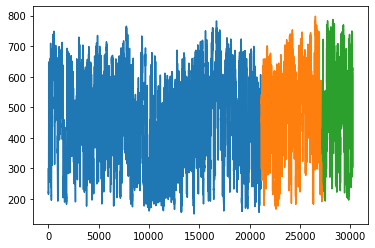

In [ ]:
# check the train test split by plotting both

plt.plot(co2_train)
plt.plot(co2_val)
plt.plot(co2_test)
plt.show()

### Create walk forward split

In [ ]:
n_val = co2_val.shape[0]
val_split = 8
val_len = n_val // val_split
assert( n_val % val_split == 0)
print('This is the length of the validation data set:', n_val)
print('This is the number of validation splits:', val_split)
print('This is the length of one validation split:', val_len)

This is the length of the validation data set: 6048
This is the number of validation splits: 8
This is the length of one validation split: 756


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
# get object that contains split indexes accorcing to the test lenght and the forecast period

#define forecast period
forecast_period = 24
tscv_val = TimeSeriesSplit(gap = 0, test_size= val_len, n_splits = val_split)
tscv_test = TimeSeriesSplit(gap = 0, test_size= forecast_period, n_splits = int(len(co2_test)/forecast_period))

In [ ]:
for train_index, test_index in tscv_val.split(co2_train_val):
    #print("TRAIN:", train_index, "TEST:", test_index)
    print(len(train_index))
    X_train, X_test = features.values[train_index], features.values[test_index]
    y_train, y_test = co2.values[train_index], co2.values[test_index]

21167
21923
22679
23435
24191
24947
25703
26459


In [ ]:
co2_train_val.shape, co2_test.shape, co2.shape, co2_val.shape

((27215,), (3024,), (30239,), (6048,))

In [ ]:
# check the number of splits for the forward validation
tscv_val.get_n_splits(), tscv_test.get_n_splits()

(8, 126)

In [ ]:
# check if the tscv splits align with the test data set
assert(tscv_val.get_n_splits() == co2_val.shape[0] / val_len)
assert(tscv_test.get_n_splits() == co2_test.shape[0] / forecast_period)

# Define the Neural Network

In [17]:
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LeakyReLU
#from fun import Dropout
import keras.backend as K
import keras

#### Todos:
# define root mean squared error loss -done
# add probabiltic prediction done
# try out activation laysers -done
# ty out otimizers -done
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [18]:
learning_rate = 0.001
n_features = 32
loss = 'mse'
optimizer = tf.keras.optimizers.Adamax(learning_rate)
activation = 'relu'
dp_rate = 0.6
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42)
#metrics=[tf.keras.metrics.RootMeanSquaredError()]

In [19]:
model_mlp = dp.MLP_2(n_features, learning_rate, activation, loss, optimizer, dp_rate)

In [20]:
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 dense_5 (Dense)             (None, 1024)              5

In [ ]:
tf.keras.utils.plot_model(model_mlp, to_file='mlp.svg', show_shapes=True, show_layer_names=True, show_layer_activations=True,expand_nested=False,show_dtype=False)

ValueError: ignored

In [ ]:
!pip install PIL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [ ]:
from PIL import ImageFont

In [ ]:
!fc-list

/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf: Liberation Sans Narrow:style=Italic
/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf: Liberation Sans:style=Regular
/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf: Liberation Mono:style=Bold Italic
/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf: Liberation Serif:style=Italic
/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf: Liberation Mono:style=Bold
/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf: Liberation Sans Narrow:style=Regular
/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf: Liberation Serif:style=Bold
/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf: Liberation Mono:style=Regular
/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf: Liberation Sans:style=Italic
/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf: Liberation Serif:style=Bold Italic
/usr/share/fonts/truet

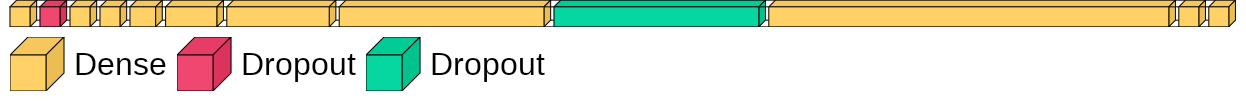

In [ ]:
import visualkeras
font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf', 32)
visualkeras.layered_view(model_mlp,  legend=True, font =font)

# Walk forward Validation

In [ ]:
callback = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    verbose = 0,
    patience = 25,
    mode = 'auto',
    restore_best_weights = True
)

In [ ]:
from numpy.random import seed

In [ ]:
seed(42)
tf.random.set_seed (42)

In [ ]:
alpha_low = 0.025
alpha_high = 0.975
lower_val, mean_val, upper_val, report_val = dp.walk_forward_deep_learning_mlp(tscv_val, co2_train_val, features_train_val, co2_val, alpha_low, alpha_high,n_features, callback ,learning_rate = learning_rate, loss = loss, optimizer = optimizer, activation = activation, dp_rate = dp_rate, initializer= initializer, batch_size =16, epochs = 100, num_preds = 75, method = 'MLP', refit = True, validation = True)
print(report_val)

20411
21167
21167
21923
21923
22679
22679
23435
23435
24191
24191
24947
24947
25703
25703
26459
MAE for MLP: 29.83 g_CO2/kWh
MAPE for MLP: 6.49 %
RMSE for MLP: 37.73 g_CO2/kWh
Pinball for lower Quantile MLP: 2.91 g_CO2/kWh
Pinball for higher Quantile MLP: 6.88 g_CO2/kWh
Interval Score MLP: 87.5843 g_CO2/kWh
Real Values insisde PI MLP: 63.86 %
R2 MLP: 91.96 %
Adjusted R2 MLP: 91.92 %


In [ ]:
pred_val_df = pd.DataFrame(mean_val)
pred_val_df.to_csv('best_mlp_mean_wf_val.csv')
pred_val_df.head() 

,0
0,529.406128
1,518.744812
2,516.133911
3,525.117310
4,532.603638


In [ ]:
upper_val_df = pd.DataFrame(upper_val)
upper_val_df.to_csv('best_mlp_upper_wf_val.csv')
upper_val_df

,0
0,576.931216
1,551.982782
2,553.168811
3,559.413754
4,567.409125
...,...
6043,454.164281
6044,443.632358
6045,439.268239
6046,383.801410


In [ ]:
lower_val_df = pd.DataFrame(lower_val)
lower_val_df.to_csv('best_mlp_lower_wf_val.csv')
lower_val_df

,0
0,486.492455
1,482.270305
2,471.172362
3,488.878004
4,500.873650
...,...
6043,394.124384
6044,379.901956
6045,366.828943
6046,338.709712


In [ ]:
mlp_test_report_01 = open("/content/drive/MyDrive/Colab Notebooks/Master_thesis/master_thesis_collab/mlp_val_report.txt", 'w')
mlp_test_report_01.write(report_val)
mlp_test_report_01.close()

In [ ]:
# split the date data
date_val = date[int(n*train_ratio):int(n*val_ratio)]
date_test = date[int(n*val_ratio):n]

In [ ]:
co2_val.head()

21167    513.506720
21168    506.521267
21169    504.916659
21170    513.695182
21171    523.851760
Name: emission_factor, dtype: float64

In [ ]:
upper_val_df = pd.DataFrame(upper_val)
upper_val_df

,0
0,566.351758
1,572.226059
2,564.327744
3,568.425998
4,592.469543
...,...
6043,437.705870
6044,445.519336
6045,441.294252
6046,402.902051


In [ ]:
lower_val_df = pd.DataFrame(lower_val)
lower_val_df

,0
0,488.444633
1,491.876933
2,485.241637
3,489.358484
4,508.518422
...,...
6043,377.073289
6044,385.505298
6045,382.800934
6046,349.915678


In [ ]:
mlp_val_df = pd.read_csv('best_mlp_mean_wf_val.csv')

In [ ]:
mlp_val_df = mlp_val_df.drop(columns='Unnamed: 0')
mlp_val_df.head()

,0
0,527.42700
1,529.80066
2,526.73694
3,532.20560
4,547.14886


In [ ]:
lower_val_df = pd.read_csv('best_mlp_lower_wf_val.csv')

In [ ]:
lower_val_df = lower_val_df.drop(columns='Unnamed: 0')
lower_val_df.head()

,0
0,488.444633
1,491.876933
2,485.241637
3,489.358484
4,508.518422


In [ ]:
upper_val_df = pd.read_csv('best_mlp_upper_wf_val.csv')

In [ ]:
upper_val_df = upper_val_df.drop(columns='Unnamed: 0')
upper_val_df.head()

,0
0,566.351758
1,572.226059
2,564.327744
3,568.425998
4,592.469543


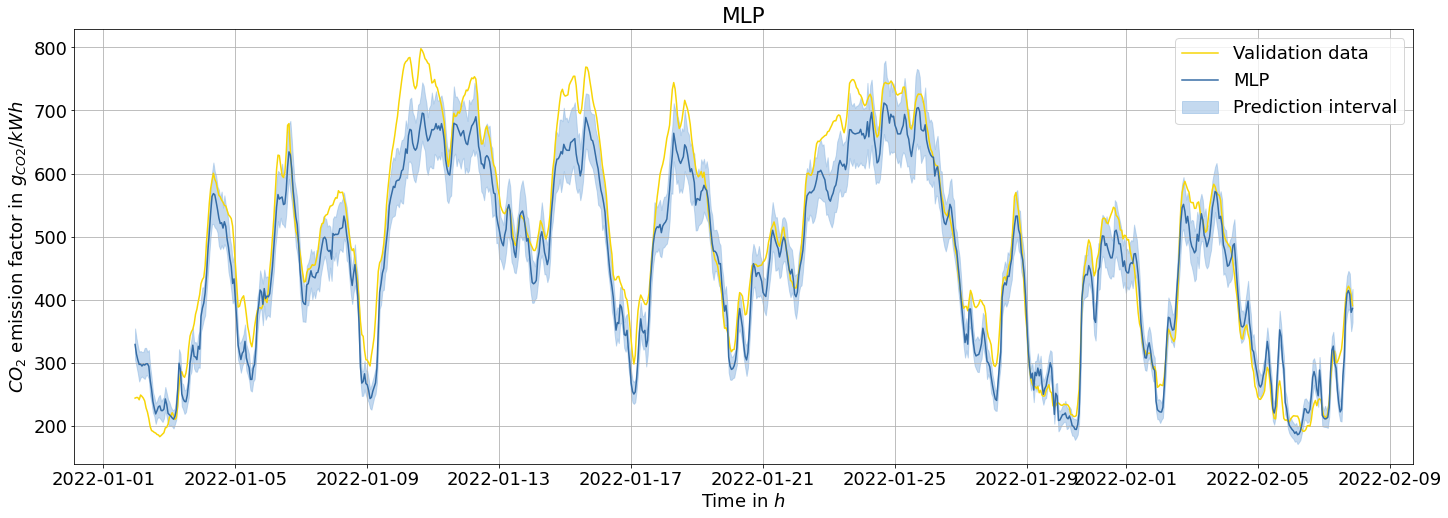

In [ ]:
fun.plot_model_uncertainty2(co2_val, mlp_val_df,lower_val_df ,upper_val_df, date_val, slice_start = '2022-01-01 23:00', slice_end =  '2022-02-15 23:00' , method = 'MLP')

# walk forward testing

In [ ]:
callback_test = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    verbose = 0,
    patience = 25,
    mode = 'auto',
    restore_best_weights = True
)

In [ ]:
#learning_rate_test = 0.001
#loss = 'mse'
#optimizer = tf.keras.optimizers.Adam(learning_rate_test)

In [ ]:
learning_rate = 0.001
loss = 'mse'
optimizer = tf.keras.optimizers.Adamax(learning_rate)
activation = 'relu'
dp_rate = 0.6
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42)
#metrics=[tf.keras.metrics.RootMeanSquaredError()]

In [ ]:
#model_mlp_test = dp.MLP(n_features, learning_rate, activation, loss, optimizer, dp_rate, metrics)

In [ ]:
alpha_low = 0.025
alpha_high = 0.975
lower_test, mean_test, upper_test, report_test = dp.walk_forward_deep_learning_mlp(tscv_test, co2, features, co2_test, alpha_low, alpha_high,n_features, callback_test ,learning_rate = learning_rate, loss = loss, optimizer = optimizer, activation = activation, dp_rate = dp_rate, initializer= initializer, batch_size =16, epochs = 100, num_preds = 75, method = 'MLP', refit = True, validation = False)
print(report_test)

27191
27215
27215
27239
27239
27263
27263
27287
27287
27311
27311
27335
27335
27359
27359
27383
27383
27407
27407
27431
27431
27455
27455
27479
27479
27503
27503
27527
27527
27551
27551
27575
27575
27599
27599
27623
27623
27647
27647
27671
27671
27695
27695
27719
27719
27743
27743
27767
27767
27791
27791
27815
27815
27839
27839
27863
27863
27887
27887
27911
27911
27935
27935
27959
27959
27983
27983
28007
28007
28031
28031
28055
28055
28079
28079
28103
28103
28127
28127
28151
28151
28175
28175
28199
28199
28223
28223
28247
28247
28271
28271
28295
28295
28319
28319
28343
28343
28367
28367
28391
28391
28415
28415
28439
28439
28463
28463
28487
28487
28511
28511
28535
28535
28559
28559
28583
28583
28607
28607
28631
28631
28655
28655
28679
28679
28703
28703
28727
28727
28751
28751
28775
28775
28799
28799
28823
28823
28847
28847
28871
28871
28895
28895
28919
28919
28943
28943
28967
28967
28991
28991
29015
29015
29039
29039
29063
29063
29087
29087
29111
29111
29135
29135
29159
29159
29183
2918

In [ ]:
print(mean_test)

NameError: ignored

In [ ]:
print(co2_test)

27215    384.171132
27216    394.529970
27217    395.021625
27218    380.836436
27219    372.334296
            ...    
30234    510.849600
30235    581.149058
30236    624.367735
30237    630.314545
30238    619.932072
Name: emission_factor, Length: 3024, dtype: float64


In [ ]:
mlp_test_df = pd.DataFrame(mean_test)
#mlp_test_df.index = date_test.values
mlp_test_df.head() 

,0
0,381.313477
1,354.147797
2,341.230652
3,324.045624
4,308.615509


In [ ]:
upper_test_df = pd.DataFrame(upper_test)
upper_test_df

,0
0,399.123680
1,370.360539
2,358.956821
3,337.883849
4,323.066547
...,...
3019,504.028336
3020,560.016443
3021,572.552466
3022,610.978592


In [ ]:
lower_test_df = pd.DataFrame(lower_test)
lower_test_df

,0
0,365.562491
1,336.620728
2,324.978386
3,310.020828
4,293.807158
...,...
3019,422.234924
3020,467.926593
3021,486.278232
3022,505.625023


In [ ]:
date_test

27215   2022-02-07 22:00:00+00:00
27216   2022-02-07 23:00:00+00:00
27217   2022-02-08 00:00:00+00:00
27218   2022-02-08 01:00:00+00:00
27219   2022-02-08 02:00:00+00:00
                   ...           
30234   2022-06-13 17:00:00+00:00
30235   2022-06-13 18:00:00+00:00
30236   2022-06-13 19:00:00+00:00
30237   2022-06-13 20:00:00+00:00
30238   2022-06-13 21:00:00+00:00
Name: datetime_de, Length: 3024, dtype: datetime64[ns, UTC]

In [ ]:
date_test.values

array(['2022-02-07T22:00:00.000000000', '2022-02-07T23:00:00.000000000',
       '2022-02-08T00:00:00.000000000', ...,
       '2022-06-13T19:00:00.000000000', '2022-06-13T20:00:00.000000000',
       '2022-06-13T21:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
mlp_test_df = pd.read_csv('best_mlp_mean_wv.csv')

In [ ]:
mlp_test_df = mlp_test_df.drop(columns='Unnamed: 0')
mlp_test_df.head()

,0
0,381.31348
1,354.14780
2,341.23065
3,324.04562
4,308.61550


In [ ]:
lower_test_df = pd.read_csv('best_mlp_lower_wv.csv')

In [ ]:
lower_test_df = lower_test_df.drop(columns='Unnamed: 0')
lower_test_df.head()

,0
0,365.562491
1,336.620728
2,324.978386
3,310.020828
4,293.807158


In [ ]:
upper_test_df = pd.read_csv('best_mlp_upper_wv.csv')

In [ ]:
upper_test_df = upper_test_df.drop(columns='Unnamed: 0')
upper_test_df.head()

,0
0,399.123680
1,370.360539
2,358.956821
3,337.883849
4,323.066547


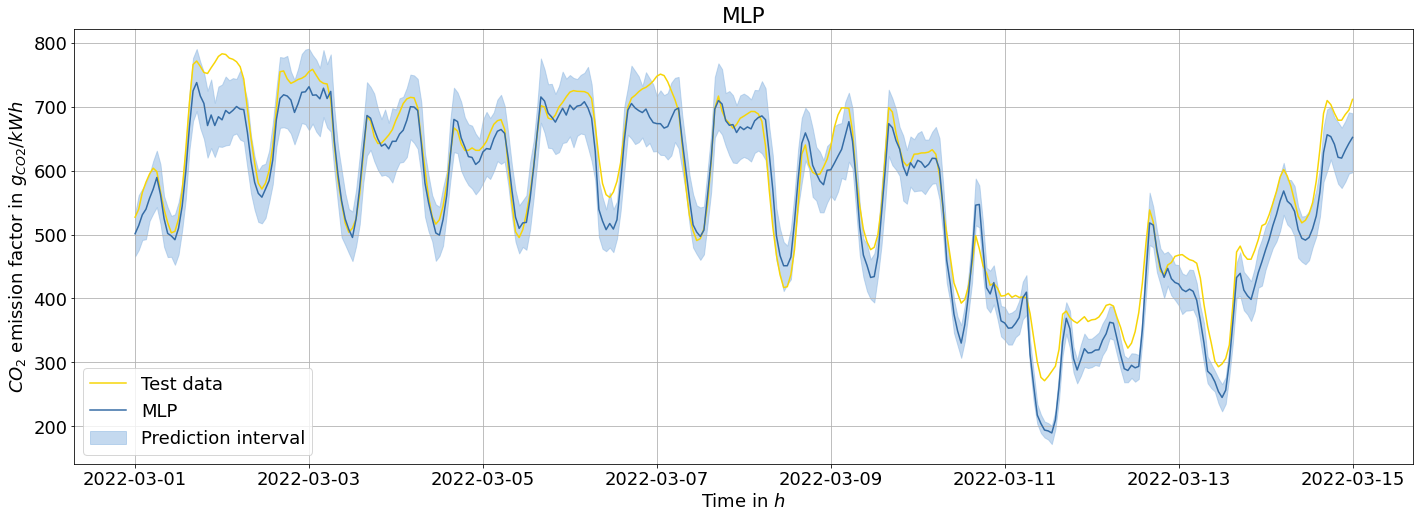

In [ ]:
fun.plot_model_uncertainty(co2_test, mlp_test_df,lower_test_df ,upper_test_df, date_test, slice_start = '2022-03-01 00:00', slice_end =  '2022-03-15 00:00' , method = 'MLP')

In [ ]:
 mlp_test_df.to_csv('best_mlp_mean_wv.csv')

In [ ]:
mlp_test_report_01 = open("/content/drive/MyDrive/Colab Notebooks/Master_thesis/master_thesis_collab/mlp_test_report_wv.txt", 'w')
mlp_test_report_01.write(report_test)
mlp_test_report_01.close()

In [ ]:
lower_test_df = pd.DataFrame(lower_test)
lower_test_df.to_csv('best_mlp_lower_wv.csv')

In [ ]:
upper_test_df = pd.DataFrame(upper_test)
upper_test_df.to_csv('best_mlp_upper_wv.csv')